In [1]:
import matplotlib 
matplotlib.use('Agg') 
from  matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


In [7]:
class Selector(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, x, y = None):
        return self
    
    def transform(self, x):
        return x.ix[:,self.columns]

class MissingValuesFiller(BaseEstimator, TransformerMixin):

    def __init__(self, default=-1000):
        self.default = default

    def fit(self, x, y=None):
        return self

    def transform(self, x):
        return x.fillna(self.default)


class ToDict(BaseEstimator,TransformerMixin):
    
    def __init__(self):
        pass
        
    def fit(self, x, y = None):
        return self
    
    def transform(self, x):
        data_as_dict = list(x.T.to_dict().values())
        return data_as_dict 
    
    
class OutlierDetect(BaseEstimator, TransformerMixin):

    def __init__(self, columns=None):
        self.columns = columns
        
    def fit(self, x, y=None):
        return self
  
    def replace(self, group):
        mean, std = group.mean(), group.std()
        outliers = (group - mean).abs() > 5*std
        group[outliers] = 5*std       
        return group
    
    def transform(self, x):
        if self.columns is None:
            self.columns = x.columns
            # outlier detect per groupf
        for col in x.columns:
             x[col]=x.groupby(['SYSTEMBAUSTEIN_ID','WARENGRUPPE_ID'])[col].transform(self.replace)
        return x.ix[:, self.columns]  
    
    
class YearMonthProcessor(BaseEstimator, TransformerMixin):
    
    def __init__(self, date_format=None):
        pass
        
    def fit(self, x, y = None):
        return self
    
    def transform(self, x):
        assert x.shape[1] == 1, "This transformer can handle 1 date"
        
        # create an empty DataFrame
        df = pd.DataFrame()
        
        df["MONTH"] = x.ix[:,0].mod(100L)
        df["YEAR"] = x.ix[:,0]//100L
            
        return df
    
def print_metrics(y_train,y_pred):
    print 'r2: %.2f, mse: %.f, med_abs: %.f' %(r2_score(y_train, y_pred),mean_squared_error(y_train, y_pred),median_absolute_error(y_train, y_pred))


In [3]:
orderdata = pd.read_csv('E:/Portfolio/data/Verkaufsauftrag_Umsatz.csv',sep=";")

In [4]:
orderdata['NU_CRY_MOH']=orderdata.ix[:,'DATUM_YEAR']*100 +orderdata.ix[:,'DATUM_MON']

In [5]:
#select train set for fitting the model
X_train = orderdata.loc[(orderdata.NU_CRY_MOH<=201604L)].reset_index()
#select test set for predictions
X_test =orderdata.loc[(orderdata.NU_CRY_MOH==201605L)].reset_index()

In [8]:
transformer = make_pipeline(
    # Select used variables
    Selector(columns=['WARENGRUPPE_ID','SYSTEMBAUSTEIN_ID','FLAECHE_ID', 'PARTNER_ID', 'FLAECHENTYP_ID',
        'FLAECHENKATEGORIE_ID','MENUE_KZ_FLAECHE','TEILNAHME_QR_NOS_KZ_FLAECHE','TEILNAHME_AUTO_QRNOS_FLAECHE',
        'TEILNAHME_MENU_FLAECHE','TEILNAHME_RF_KZ_FLAECHE','TEILNAHME_DYN_QRNOS_KZ_FLAECHE','RETOUREN_VEREINBARUNG_FLAECHE',
        'ORT_FLAECHE','VENUE_KATEGORIE_FLAECHE','QM_VK_FLAECHE','DATUM_MOH','DATUM_YEAR','KOLL_AVG','KOLL_LM',
        'ABSCHRIFTEN_LM','UMSATZ_LM','ABVERKAUFSMENGE_LM'
    ]),

    # combine features
    make_union(
        make_pipeline(
            Selector(columns=['WARENGRUPPE_ID','SYSTEMBAUSTEIN_ID','FLAECHE_ID', 'PARTNER_ID', 'FLAECHENTYP_ID',
        'FLAECHENKATEGORIE_ID','MENUE_KZ_FLAECHE','TEILNAHME_QR_NOS_KZ_FLAECHE','TEILNAHME_AUTO_QRNOS_FLAECHE',
        'TEILNAHME_MENU_FLAECHE','TEILNAHME_RF_KZ_FLAECHE','TEILNAHME_DYN_QRNOS_KZ_FLAECHE','RETOUREN_VEREINBARUNG_FLAECHE',
        'QM_VK_FLAECHE','DATUM_MOH','DATUM_YEAR','KOLL_AVG','KOLL_LM','ABSCHRIFTEN_LM','UMSATZ_LM','ABVERKAUFSMENGE_LM'
            ]),
        ),
        make_pipeline(
            Selector(columns=['ORT_FLAECHE']),
            ToDict(),
            DictVectorizer(sparse=False)
        ),
        make_pipeline(
            Selector(columns=['VENUE_KATEGORIE_FLAECHE']),
            ToDict(),
            DictVectorizer(sparse=False)
        )
    ),
    Imputer(missing_values='NaN', strategy='median', axis=0),
    StandardScaler(with_mean=False)
) 

outlier= make_pipeline(
    # Select used variables
    Selector(columns=['WARENGRUPPE_ID','SYSTEMBAUSTEIN_ID','Y_LABLE']),
    OutlierDetect(columns='Y_LABLE')
)



# train data set 
X_train_trans = transformer.fit_transform(X_train)

#remove from train outlier
y_train = outlier.fit_transform(X_train)

# test data set 
X_test_trans  = transformer.transform(X_test)
#remove from train outlier
y_test = outlier.fit_transform(X_test)


# models to combine/stack
stacker_classier = [
     ('rf',RandomForestRegressor(n_estimators=250,n_jobs=1,random_state=np.random.RandomState(123)))
    ,('et',ExtraTreesRegressor(n_estimators=250,n_jobs=1,random_state=np.random.RandomState(123)))
    ,('knn', KNeighborsRegressor(5))
    ,('dt', DecisionTreeRegressor(max_depth=4))
    ,('gbr',GradientBoostingRegressor(n_estimators=250, max_depth=4, min_samples_split=1,learning_rate=0.01, loss='ls',random_state=np.random.RandomState(123)))
]

pred_stacker = pd.DataFrame()
model_names =[]

#for each model the result of prediction is stored to be used in a LinearRegression
for clf_name, clf in stacker_classier:
    print(clf_name)
    model_names.append(clf_name)
    clf.fit(X_train_trans,y_train)
    pred_stacker[clf_name] = clf.predict(X_test_trans)
    print_metrics(y_test, pred_stacker[clf_name])
    
    
# Calculate avg of all models
pred_stacker['bag_avg'] = pred_stacker[model_names].apply(lambda d : d.mean(), axis = 1)
print('\nBagging_Average')
print_metrics(y_test,pred_stacker['bag_avg'])

# Linear regression of all models
lm = LinearRegression(copy_X = True)
lm.fit(pred_stacker[model_names],y_test)
pred_stacker['stack_lreg'] = lm.predict(pred_stacker[model_names])
print('\nRegression_stacking')
print_metrics(y_test,pred_stacker['stack_lreg'])


rf
r2: 0.85, mse: 3629, med_abs: 15
et
r2: 0.86, mse: 3391, med_abs: 16
knn
r2: 0.80, mse: 5027, med_abs: 18
dt
r2: 0.79, mse: 5177, med_abs: 16
gbr
r2: 0.80, mse: 4894, med_abs: 16

Bagging_Average
r2: 0.83, mse: 4070, med_abs: 15

Regression_stacking
r2: 0.92, mse: 2067, med_abs: 16


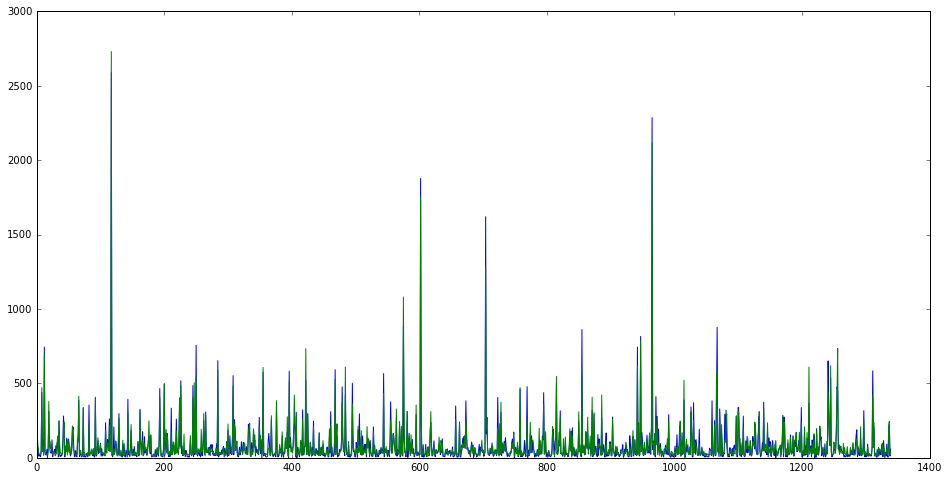

In [11]:
#Plot true values of y_test vs the predictions of X_test
fig1 = plt.figure(figsize=(16,8))
ax1 = fig1.add_subplot(111)
ax1.plot(y_test.reshape(-1,1))
ax1.plot(pred_stacker['stack_lreg'].reshape(-1,1))

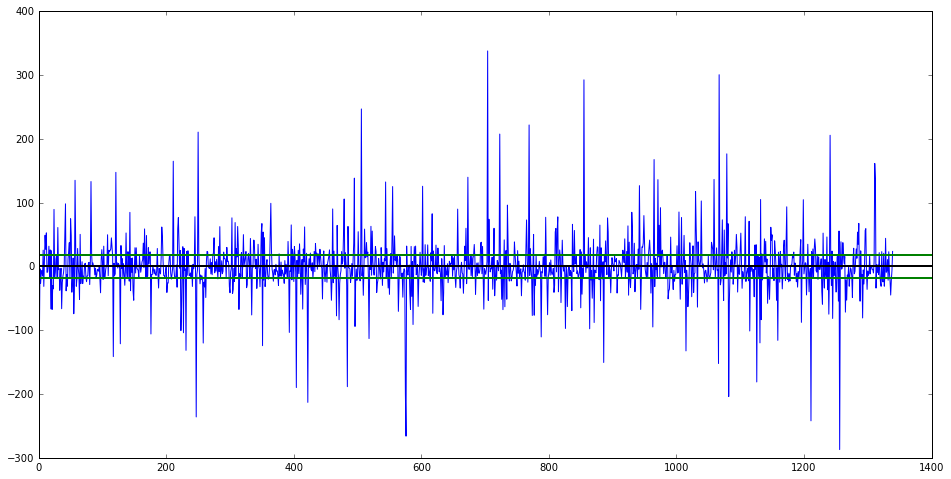

In [12]:
#Plot the errors of X_Test - prediction 

fig1 = plt.figure(figsize=(16,8))
ax1 = fig1.add_subplot(111)
ax1.plot(X_test.Y_LABLE.reshape(-1,1)-pred_stacker['stack_lreg'].reshape(-1,1))
ax1.axhline(0, color='black', lw=2)
ax1.axhline(18, color='green', lw=2)
ax1.axhline(-18, color='green', lw=2)


In [14]:
#Save the prediction into a csv file to analyse it further
X_test['pred']=np.floor(pred_stacker['stack_lreg'])
X_test.to_csv('Predict_Orderquantity.csv',sep=";",index=False)